In [23]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import time
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
# from params import par
from model import DeepVO
from data_helper import get_data_info, SortedRandomBatchSampler, ImageSequenceDataset, get_partition_data_info

In [24]:
DATA_PATH = '/home/davidgogh96/DeepVO/'
class Parameters():
    def __init__(self):
        self.n_processors = 8
        # Path
        self.data_dir =  DATA_PATH + 'KITTI'
        self.image_dir = self.data_dir + '/images/'
        self.pose_dir = self.data_dir + '/pose_GT/'

        self.train_video = ['00', '01', '02', '05', '08', '10']
        self.valid_video = ['04', '06', '07']
        self.partition = None  # partition videos in 'train_video' to train / valid dataset  #0.8


        # Data Preprocessing
        self.resize_mode = 'rescale'  # choice: 'crop' 'rescale' None
#         self.img_w = 608   # original size is about 1226
#         self.img_h = 184   # original size is about 370
        self.img_w = 304   # original size is about 1226
        self.img_h = 92   # original size is about 370
#         self.img_w = 640   # original size is about 1226
#         self.img_h = 192   # original size is about 370
        self.img_means = (-0.14968217427134656, -0.12941663107068363, -0.1320610301921484)
        self.img_stds = (1, 1, 1)  #(0.309122, 0.315710, 0.3226514)
        self.minus_point_5 = True

        self.seq_len = (5, 7)
        self.sample_times = 3

        # Data info path
        self.train_data_info_path = 'datainfo/train_df_t{}_v{}_p{}_seq{}x{}_sample{}.pickle'.format(''.join(self.train_video), ''.join(self.valid_video), self.partition, self.seq_len[0], self.seq_len[1], self.sample_times)
        self.valid_data_info_path = 'datainfo/valid_df_t{}_v{}_p{}_seq{}x{}_sample{}.pickle'.format(''.join(self.train_video), ''.join(self.valid_video), self.partition, self.seq_len[0], self.seq_len[1], self.sample_times)


        # Model
        self.rnn_hidden_size = 1000
        self.conv_dropout = (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.5)
        self.rnn_dropout_out = 0.5
        self.rnn_dropout_between = 0   # 0: no dropout
        self.clip = None
        self.batch_norm = True
        # Training
        self.epochs = 50
        self.batch_size = 8
        self.pin_mem = False
        self.optim = {'opt': 'Adam'}
#         {'opt': 'Adagrad', 'lr': 0.0005}
                    # Choice:
                    # {'opt': 'Adagrad', 'lr': 0.001}
                    # {'opt': 'Adam'}
                    # {'opt': 'Cosine', 'T': 100 , 'lr': 0.001}

        # Pretrain, Resume training
        self.pretrained_flownet = DATA_PATH + '/weights/pretrained/flownets_bn_EPE2.459.pth.tar'
                                # Choice:
                                # None
                                # './pretrained/flownets_bn_EPE2.459.pth.tar'  
                                # './pretrained/flownets_EPE1.951.pth.tar'
        self.resume = True  # resume training
        self.resume_t_or_v = '.train'
        self.load_model_path = 'models/t{}_v{}_im{}x{}_s{}x{}_b{}_rnn{}_{}.model{}'.format(''.join(self.train_video), ''.join(self.valid_video), self.img_h, self.img_w, self.seq_len[0], self.seq_len[1], self.batch_size, self.rnn_hidden_size, '_'.join([k+str(v) for k, v in self.optim.items()]), self.resume_t_or_v)
        self.load_optimizer_path = 'models/t{}_v{}_im{}x{}_s{}x{}_b{}_rnn{}_{}.optimizer{}'.format(''.join(self.train_video), ''.join(self.valid_video), self.img_h, self.img_w, self.seq_len[0], self.seq_len[1], self.batch_size, self.rnn_hidden_size, '_'.join([k+str(v) for k, v in self.optim.items()]), self.resume_t_or_v)

        self.record_path = 'records/t{}_v{}_im{}x{}_s{}x{}_b{}_rnn{}_{}.txt'.format(''.join(self.train_video), ''.join(self.valid_video), self.img_h, self.img_w, self.seq_len[0], self.seq_len[1], self.batch_size, self.rnn_hidden_size, '_'.join([k+str(v) for k, v in self.optim.items()]))
        self.save_model_path = 'models/t{}_v{}_im{}x{}_s{}x{}_b{}_rnn{}_{}.model'.format(''.join(self.train_video), ''.join(self.valid_video), self.img_h, self.img_w, self.seq_len[0], self.seq_len[1], self.batch_size, self.rnn_hidden_size, '_'.join([k+str(v) for k, v in self.optim.items()]))
        self.save_optimzer_path = 'models/t{}_v{}_im{}x{}_s{}x{}_b{}_rnn{}_{}.optimizer'.format(''.join(self.train_video), ''.join(self.valid_video), self.img_h, self.img_w, self.seq_len[0], self.seq_len[1], self.batch_size, self.rnn_hidden_size, '_'.join([k+str(v) for k, v in self.optim.items()]))


        if not os.path.isdir(os.path.dirname(self.record_path)):
            os.makedirs(os.path.dirname(self.record_path))
        if not os.path.isdir(os.path.dirname(self.save_model_path)):
            os.makedirs(os.path.dirname(self.save_model_path))
        if not os.path.isdir(os.path.dirname(self.save_optimzer_path)):
            os.makedirs(os.path.dirname(self.save_optimzer_path))
        if not os.path.isdir(os.path.dirname(self.train_data_info_path)):
            os.makedirs(os.path.dirname(self.train_data_info_path))

par = Parameters()



In [16]:
# Write all hyperparameters to record_path
mode = 'a' if par.resume else 'w'
with open(par.record_path, mode) as f:
    f.write('\n'+'='*50 + '\n')
    f.write('\n'.join("%s: %s" % item for item in vars(par).items()))
    f.write('\n'+'='*50 + '\n')

# Prepare Data
if os.path.isfile(par.train_data_info_path) and os.path.isfile(par.valid_data_info_path):
    print('Load data info from {}'.format(par.train_data_info_path))
    train_df = pd.read_pickle(par.train_data_info_path)
    valid_df = pd.read_pickle(par.valid_data_info_path)
else:
    print('Create new data info')
    if par.partition != None:
        partition = par.partition
        train_df, valid_df = get_partition_data_info(partition, par.train_video, par.seq_len, overlap=1, sample_times=par.sample_times, shuffle=True, sort=True)
    else:
        train_df = get_data_info(folder_list=par.train_video, seq_len_range=par.seq_len, overlap=1, sample_times=par.sample_times)	
        valid_df = get_data_info(folder_list=par.valid_video, seq_len_range=par.seq_len, overlap=1, sample_times=par.sample_times)
    # save the data info
    train_df.to_pickle(par.train_data_info_path)
    valid_df.to_pickle(par.valid_data_info_path)

train_sampler = SortedRandomBatchSampler(train_df, par.batch_size, drop_last=True)
train_dataset = ImageSequenceDataset(train_df, par.resize_mode, (par.img_w, par.img_h), par.img_means, par.img_stds, par.minus_point_5)
train_dl = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=par.n_processors, pin_memory=par.pin_mem)

valid_sampler = SortedRandomBatchSampler(valid_df, par.batch_size, drop_last=True)
valid_dataset = ImageSequenceDataset(valid_df, par.resize_mode, (par.img_w, par.img_h), par.img_means, par.img_stds, par.minus_point_5)
valid_dl = DataLoader(valid_dataset, batch_sampler=valid_sampler, num_workers=par.n_processors, pin_memory=par.pin_mem)

print('Number of samples in training dataset: ', len(train_df.index))
print('Number of samples in validation dataset: ', len(valid_df.index))
print('='*50)


# Model
M_deepvo = DeepVO(par.img_h, par.img_w, par.batch_norm)
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('CUDA used.')
    M_deepvo = M_deepvo.cuda()


# Load FlowNet weights pretrained with FlyingChairs
# NOTE: the pretrained model assumes image rgb values in range [-0.5, 0.5]
if par.pretrained_flownet and not par.resume:
    if use_cuda:
        pretrained_w = torch.load(par.pretrained_flownet)
    else:
        pretrained_w = torch.load(par.pretrained_flownet_flownet, map_location='cpu')
    print('Load FlowNet pretrained model')
    # Use only conv-layer-part of FlowNet as CNN for DeepVO
    model_dict = M_deepvo.state_dict()
    update_dict = {k: v for k, v in pretrained_w['state_dict'].items() if k in model_dict}
    model_dict.update(update_dict)
    M_deepvo.load_state_dict(model_dict)


# Create optimizer
if par.optim['opt'] == 'Adam':
    optimizer = torch.optim.Adam(M_deepvo.parameters(), lr=0.001, betas=(0.9, 0.999))
elif par.optim['opt'] == 'Adagrad':
    optimizer = torch.optim.Adagrad(M_deepvo.parameters(), lr=par.optim['lr'])
elif par.optim['opt'] == 'Cosine':
    optimizer = torch.optim.SGD(M_deepvo.parameters(), lr=par.optim['lr'])
    T_iter = par.optim['T']*len(train_dl)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_iter, eta_min=0, last_epoch=-1)

# Load trained DeepVO model and optimizer
if par.resume:
    M_deepvo.load_state_dict(torch.load(par.load_model_path))
    optimizer.load_state_dict(torch.load(par.load_optimizer_path))
    print('Load model from: ', par.load_model_path)
    print('Load optimizer from: ', par.load_optimizer_path)


# Train
print('Record loss in: ', par.record_path)
min_loss_t = 1e10
min_loss_v = 1e10
M_deepvo.train()
t_loss_list = []
v_loss_list = []
for ep in tnrange(par.epochs):
    st_t = time.time()
#     print('='*50)
    # Train
    M_deepvo.train()
    loss_mean = 0
    
    i = 1
    progress_bar = tqdm(train_dl, desc='Training')
    for batch_idx, (_, t_x, t_y) in enumerate(progress_bar):
#     for _, t_x, t_y in train_dl:
        if use_cuda:
            t_x = t_x.cuda(non_blocking=par.pin_mem)
            t_y = t_y.cuda(non_blocking=par.pin_mem)
        ls = M_deepvo.step(t_x, t_y, optimizer).data.cpu().numpy()
        t_loss_list.append(float(ls))
        loss_mean += float(ls)
        if par.optim == 'Cosine':
            lr_scheduler.step()
        progress_bar.set_description(
        'Epoch: {} loss: {:.4f}'.format(
            ep, loss_mean / (batch_idx + 1)))
    print('Train take {:.1f} sec'.format(time.time()-st_t))
    loss_mean /= len(train_dl)

    # Validation
    st_t = time.time()
    M_deepvo.eval()
    loss_mean_valid = 0
    
    progress_bar = tqdm(valid_dl, desc='Validating')
    for batch_idx, (_, v_x, v_y) in enumerate(progress_bar):
        if use_cuda:
            v_x = v_x.cuda(non_blocking=par.pin_mem)
            v_y = v_y.cuda(non_blocking=par.pin_mem)
        v_ls = M_deepvo.get_loss(v_x, v_y).data.cpu().numpy()
        v_loss_list.append(float(v_ls))
        loss_mean_valid += float(v_ls)
        progress_bar.set_description(
        'Epoch: {} loss: {:.4f}'.format(
            ep, loss_mean_valid / (batch_idx + 1)))
    print('Valid take {:.1f} sec'.format(time.time()-st_t))
    loss_mean_valid /= len(valid_dl)


    f = open(par.record_path, 'a')
    f.write('Epoch {}\ntrain loss mean: {}, std: {:.2f}\nvalid loss mean: {}, std: {:.2f}\n'.format(ep+1, loss_mean, np.std(t_loss_list), loss_mean_valid, np.std(v_loss_list)))
    print('Epoch {}\ntrain loss mean: {}, std: {:.2f}\nvalid loss mean: {}, std: {:.2f}\n'.format(ep+1, loss_mean, np.std(t_loss_list), loss_mean_valid, np.std(v_loss_list)))

    # Save model
    # save if the valid loss decrease
    check_interval = 1
    if loss_mean_valid < min_loss_v and ep % check_interval == 0:
        min_loss_v = loss_mean_valid
        print('Save model at ep {}, mean of valid loss: {}'.format(ep+1, loss_mean_valid))  # use 4.6 sec 
        torch.save(M_deepvo.state_dict(), par.save_model_path+'.valid')
        torch.save(optimizer.state_dict(), par.save_optimzer_path+'.valid')
    # save if the training loss decrease
    check_interval = 1
    if loss_mean < min_loss_t and ep % check_interval == 0:
        min_loss_t = loss_mean
        print('Save model at ep {}, mean of train loss: {}'.format(ep+1, loss_mean))
        torch.save(M_deepvo.state_dict(), par.save_model_path+'.train')
        torch.save(optimizer.state_dict(), par.save_optimzer_path+'.train')
    f.close()



Load data info from datainfo/train_df_t000102050810_v04060709_pNone_seq5x7_sample3.pickle
Number of samples in training dataset:  10982
Number of samples in validation dataset:  2425
CUDA used.


FileNotFoundError: [Errno 2] No such file or directory: 'models/t000102050810_v04060709_im384x1024_s5x7_b8_rnn1000_optAdam.model.train'

In [20]:
import glob
# videos_to_test = ['04', '05', '07', '10', '09']
videos_to_test = ['00', '02', '08', '09']
videos_to_test += ['01', '04', '05', '06', '07', '10']

# Path
# load_model_path = DATA_PATH + 'weights/models/t000102050809_v04060710_im184x608_s5x7_b8_rnn1000_optAdagrad_lr0.0005.model.train'
load_model_path = par.load_model_path   #choose the model you want to load
save_dir = 'result/'  # directory to save prediction answer
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


# Load model
M_deepvo = DeepVO(par.img_h, par.img_w, par.batch_norm)
use_cuda = torch.cuda.is_available()
if use_cuda:
    M_deepvo = M_deepvo.cuda()
    M_deepvo.load_state_dict(torch.load(load_model_path))
else:
    M_deepvo.load_state_dict(torch.load(load_model_path, map_location={'cuda:0': 'cpu'}))
print('Load model from: ', load_model_path)



# Data
n_workers = 1
seq_len = int((par.seq_len[0]+par.seq_len[1])/2)
overlap = seq_len - 1
print('seq_len = {},  overlap = {}'.format(seq_len, overlap))
batch_size = par.batch_size

for test_video in videos_to_test:
    df = get_data_info(folder_list=[test_video], seq_len_range=[seq_len, seq_len], overlap=overlap, sample_times=1, shuffle=False, sort=False)
    df = df.loc[df.seq_len == seq_len]  # drop last
    dataset = ImageSequenceDataset(df, par.resize_mode, (par.img_w, par.img_h), par.img_means, par.img_stds, par.minus_point_5)
    df.to_csv('test_df.csv')
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)
    gt_pose = np.load('{}{}.npy'.format(par.pose_dir, test_video))  # (n_images, 6)

    # Predict
    M_deepvo.eval()
    has_predict = False
    answer = [[0.0]*6, ]
    st_t = time.time()
    n_batch = len(dataloader)
    for i, batch in enumerate(dataloader):
        print('{} / {}'.format(i, n_batch), end='\r', flush=True)
        _, x, y = batch
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        batch_predict_pose = M_deepvo.forward(x)

        # Record answer
        batch_predict_pose = batch_predict_pose.data.cpu().numpy()
        if i == 0:
            for pose in batch_predict_pose[0]:
                # use all predicted pose in the first prediction
                for i in range(len(pose)):
                    # Convert predicted relative pose to absolute pose by adding last pose
                    pose[i] += answer[-1][i]
                answer.append(pose.tolist())
            batch_predict_pose = batch_predict_pose[1:]

        for predict_pose_seq in batch_predict_pose:
        # use only last predicted pose in the following prediction
            last_pose = predict_pose_seq[-1]
            for i in range(len(last_pose)):
                last_pose[i] += answer[-1][i]
            answer.append(last_pose.tolist())
    print('len(answer): ', len(answer))
    print('expect len: ', len(glob.glob('{}{}/*.png'.format(par.image_dir, test_video))))
    print('Predict use {} sec'.format(time.time() - st_t))


    # Save answer
    with open('{}/out_{}.txt'.format(save_dir, test_video), 'w') as f:
        for pose in answer:
            if type(pose) == list:
                f.write(', '.join([str(p) for p in pose]))
            else:
                f.write(str(pose))
            f.write('\n')


    # Calculate loss
    gt_pose = np.load('{}{}.npy'.format(par.pose_dir, test_video))  # (n_images, 6)
    loss = 0
    for t in range(len(gt_pose)):
        angle_loss = np.sum((answer[t][:3] - gt_pose[t,:3]) ** 2)
        translation_loss = np.sum((answer[t][3:] - gt_pose[t,3:]) ** 2)
        loss = (100 * angle_loss + translation_loss)
    loss /= len(gt_pose)
    print('Loss = ', loss)
    print('='*50)

Load model from:  models/t000102050810_v040607_im92x304_s5x7_b8_rnn1000_optAdam.model.train
seq_len = 6,  overlap = 5
Folder 00 finish in 0.020549535751342773 sec


Process Process-11:
Traceback (most recent call last):
  File "/home/davidgogh96/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/davidgogh96/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/davidgogh96/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/davidgogh96/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/davidgogh96/DeepVO/data_helper.py", line 208, in __getitem__
    img_as_tensor = self.transformer(img_as_img)


KeyboardInterrupt: 

  File "/home/davidgogh96/anaconda3/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "/home/davidgogh96/anaconda3/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg/torchvision/transforms/transforms.py", line 175, in __call__
    return F.resize(img, self.size, self.interpolation)
  File "/home/davidgogh96/anaconda3/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg/torchvision/transforms/functional.py", line 206, in resize
    return img.resize(size[::-1], interpolation)
  File "/home/davidgogh96/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 1765, in resize
    return self._new(self.im.resize(size, resample, box))
KeyboardInterrupt


Video 00
mse_rotate:  27221.599475948922
mse_translate:  2176.18689232185


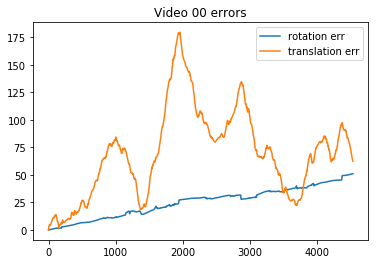

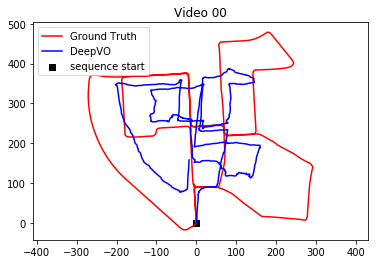

Video 01
mse_rotate:  1634.5936947299865
mse_translate:  1638.058353976944


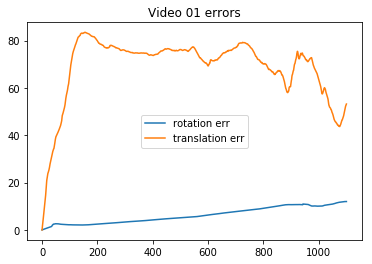

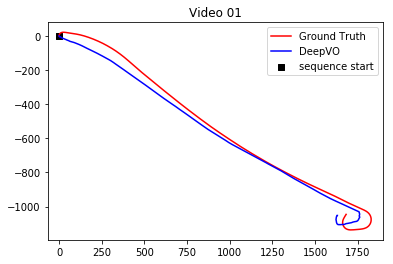

Video 02
mse_rotate:  37399.08833111559
mse_translate:  36148.33639697039


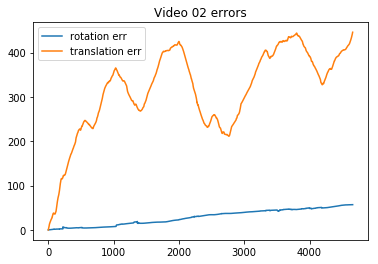

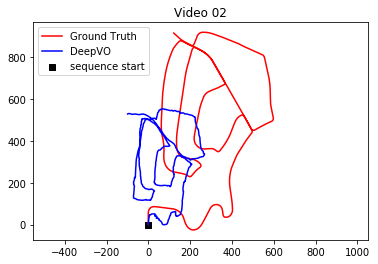

Video 05
mse_rotate:  2465.9493692887154
mse_translate:  3240.488752104404


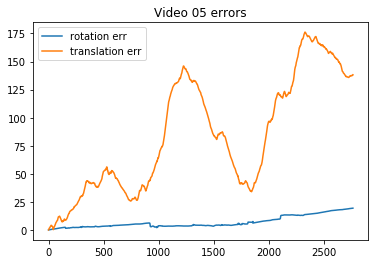

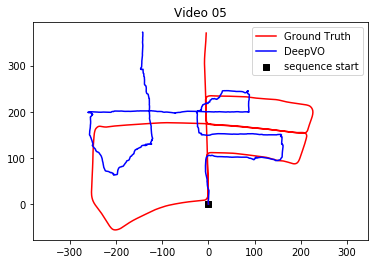

Video 08
mse_rotate:  13711.354302997916
mse_translate:  30653.01846148103


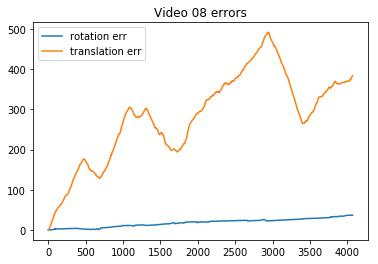

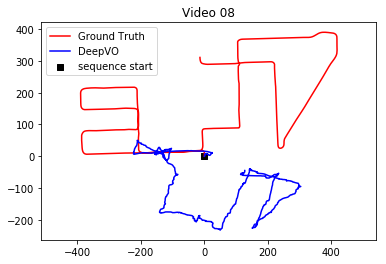

Video 10
mse_rotate:  7900.006585813784
mse_translate:  32805.42000628658


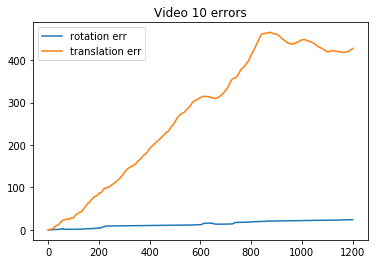

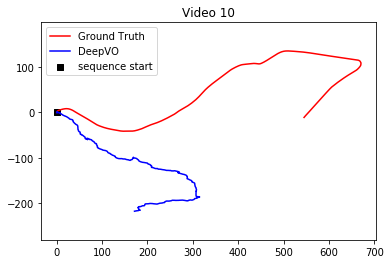

Video 04
mse_rotate:  286.76354523015726
mse_translate:  3469.9094148787613


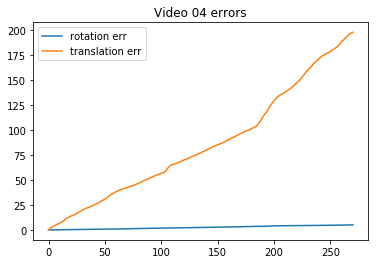

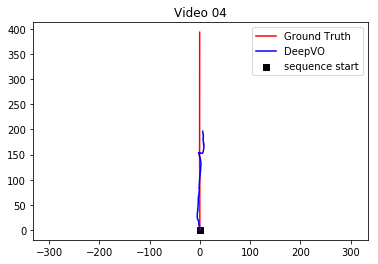

Video 06
mse_rotate:  681.2179785932474
mse_translate:  15107.02646247343


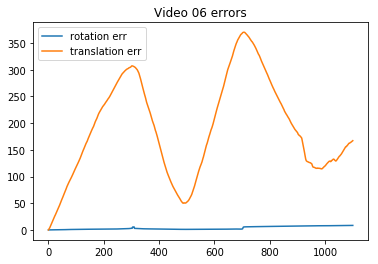

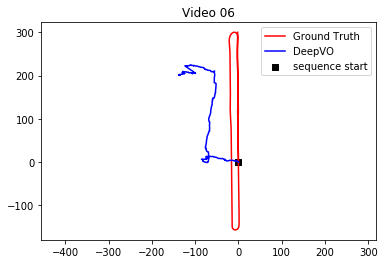

Video 07
mse_rotate:  693.7029350741493
mse_translate:  10226.214929247206


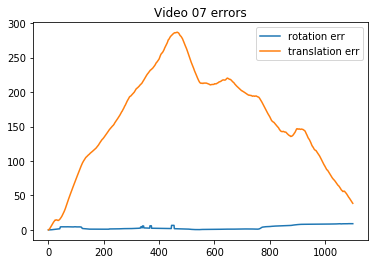

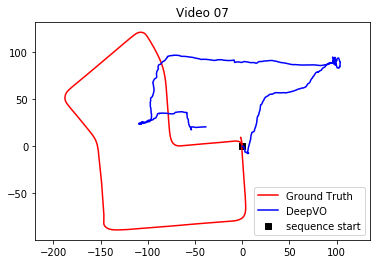

Video 09
mse_rotate:  3559.1278204502637
mse_translate:  60634.10950812892


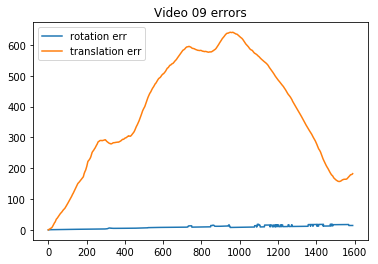

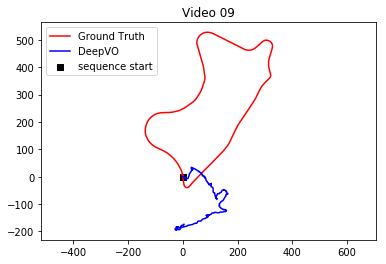

In [22]:
import matplotlib.pyplot as plt
plt.ion()

pose_GT_dir = par.pose_dir  #'KITTI/pose_GT/'
predicted_result_dir = './result/'
gradient_color = False

def plot_route(gt, out, c_gt='g', c_out='r'):
    x_idx = 3
    y_idx = 5
    x = [v for v in gt[:, x_idx]]
    y = [v for v in gt[:, y_idx]]
    plt.plot(x, y, color=c_gt, label='Ground Truth')
    #plt.scatter(x, y, color='b')

    x = [v for v in out[:, x_idx]]
    y = [v for v in out[:, y_idx]]
    plt.plot(x, y, color=c_out, label='DeepVO')
    #plt.scatter(x, y, color='b')
    plt.gca().set_aspect('equal', adjustable='datalim')


# Load in GT and predicted pose
video_list = ['00', '01', '02', '05', '08', '10']
video_list += ['04', '06', '07', '09']


for video in video_list:
    print('='*50)
    print('Video {}'.format(video))

    GT_pose_path = '{}{}.npy'.format(pose_GT_dir, video)
    gt = np.load(GT_pose_path)
    pose_result_path = '{}out_{}.txt'.format(predicted_result_dir, video)
    with open(pose_result_path) as f_out:
        out = [l.split('\n')[0] for l in f_out.readlines()]
        for i, line in enumerate(out):
            out[i] = [float(v) for v in line.split(',')]
        out = np.array(out)
        mse_rotate = 100 * np.mean((out[:, :3] - gt[:, :3])**2)
        mse_translate = np.mean((out[:, 3:] - gt[:, 3:])**2)
        print('mse_rotate: ', mse_rotate)
        print('mse_translate: ', mse_translate)
        plt.clf()
        plt.title('Video {} errors'.format(video))
        plt.plot(np.linalg.norm(out[:, :3] - gt[:, :3], axis=1), label='rotation err')
        plt.plot(np.linalg.norm(out[:, 3:] - gt[:, 3:], axis=1), label='translation err')
        plt.legend()
        save_name = '{}route_{}_err.png'.format(predicted_result_dir, video)
        plt.savefig(save_name)
        plt.show()
        


    if gradient_color:
        # plot gradient color
        step = 200
        plt.clf()
        plt.scatter([gt[0][3]], [gt[0][5]], label='sequence start', marker='s', color='k')
        for st in range(0, len(out), step):
            end = st + step
            g = max(0.2, st/len(out))
            c_gt = (0, g, 0)
            c_out = (1, g, 0)
            plot_route(gt[st:end], out[st:end], c_gt, c_out)
            if st == 0:
                plt.legend()
            plt.title('Video {}'.format(video))
            save_name = '{}route_{}_gradient.png'.format(predicted_result_dir, video)
        plt.savefig(save_name)
    else:
        # plot one color
        plt.clf()
        plt.scatter([gt[0][3]], [gt[0][5]], label='sequence start', marker='s', color='k')
        plot_route(gt, out, 'r', 'b')
        plt.legend()
        plt.title('Video {}'.format(video))
        save_name = '{}route_{}.png'.format(predicted_result_dir, video)
        plt.savefig(save_name)
        plt.show()

In [23]:
plt.show()